<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Катбуст" data-toc-modified-id="Катбуст-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Катбуст</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Проверка на адекватность</a></span></li><li><span><a href="#Важность-признаков" data-toc-modified-id="Важность-признаков-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Важность признаков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Проверка на адекватность</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговый вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import(
    RandomizedSearchCV,
    train_test_split,
    TimeSeriesSplit
)

from sklearn.preprocessing import (
    MinMaxScaler
)

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import(
    RandomForestRegressor
)

from catboost import (
    CatBoostRegressor
)

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.sort_index(inplace=True)

In [4]:
data = data.resample('1h').sum()

In [5]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [7]:
data.isna().sum()

num_orders    0
dtype: int64

In [8]:
data.index.is_monotonic

True

### Вывод

Импортированы необходимые библиотеки, данные подготовлены - прочитаны и рессемплированны по одному часу для дальнейшего анализа с суммированием заказов, в дальнейшем можно взять среднее значение и от него опираться. Пропусков нету, серьезная предобработка не требуется.

## Анализ

Я решил посмотреть как сильно похожи дни друг на друга. Для этого я собрал корреляцию дня одного месяца с другим таким же днем, но другого месяца, а потом посмотрел стандратное отклонение и среднее значение и в целом нарисовал боксплот, проверил, на наличие выбросов.

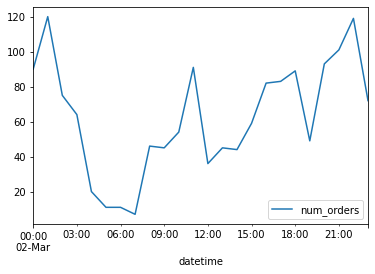

In [9]:
data['2018-03-02':'2018-03-02'].plot();

In [10]:
correlations = []
for day in range(1, 31):
    if day < 10:
        correlations.append(pd.Series(data[f'2018-03-0{day}':f'2018-03-0{day}'].values.ravel())
                        .corr(pd.Series(data[f'2018-04-0{day}':f'2018-04-0{day}'].values.ravel())))
    else:
        correlations.append(pd.Series(data[f'2018-03-{day}':f'2018-03-{day}'].values.ravel())
                        .corr(pd.Series(data[f'2018-04-{day}':f'2018-04-{day}'].values.ravel())))

In [11]:
np.mean(correlations)

0.5458387357267268

In [12]:
np.std(correlations)

0.1355405210976782

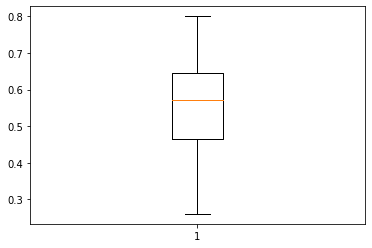

In [13]:
plt.boxplot(correlations);

<AxesSubplot:xlabel='datetime'>

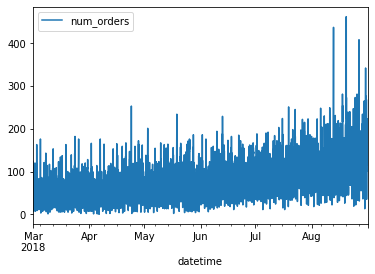

In [14]:
data.plot()

In [15]:
decomposed = seasonal_decompose(data)

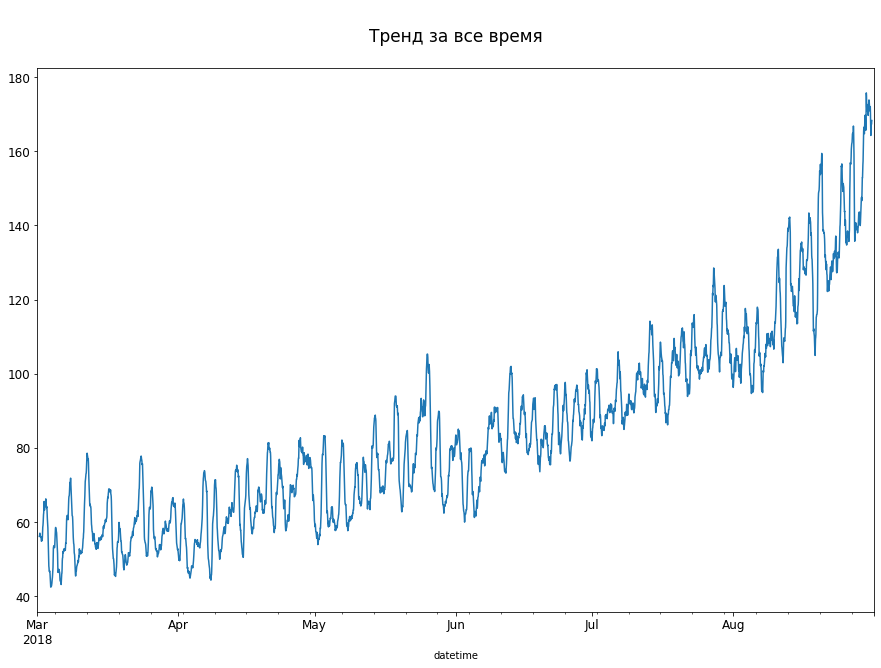

In [16]:
decomposed.trend.plot(ax=plt.gca(), figsize=(15, 10), fontsize=12).set_title('\n'+'Тренд за все время'+'\n', fontsize=17);

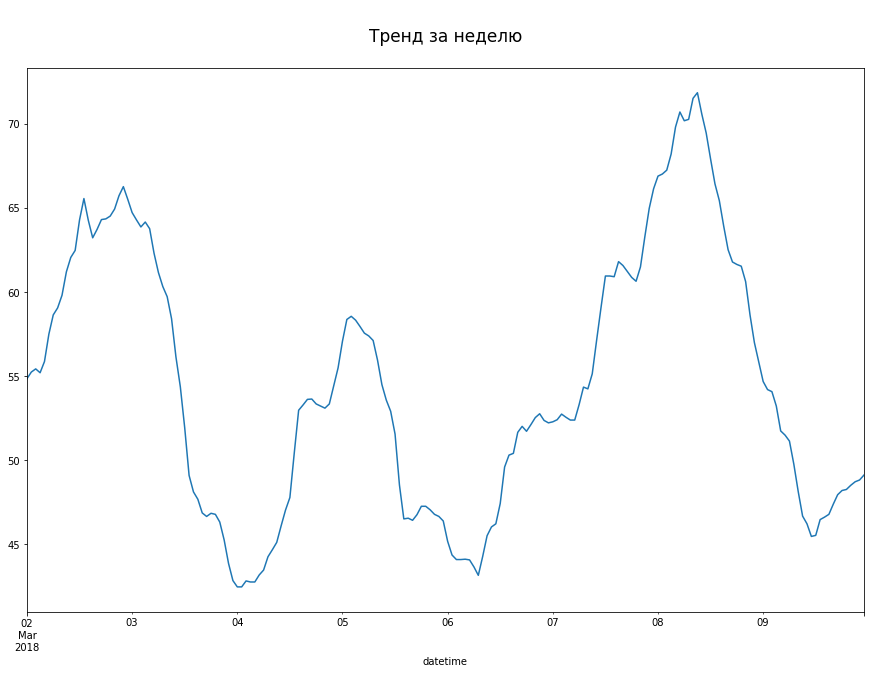

In [17]:
decomposed.trend['2018-03-02':'2018-03-09'].plot(ax=plt.gca(), figsize=(15, 10)).set_title('\n'+'Тренд за неделю'+'\n', fontsize=17);

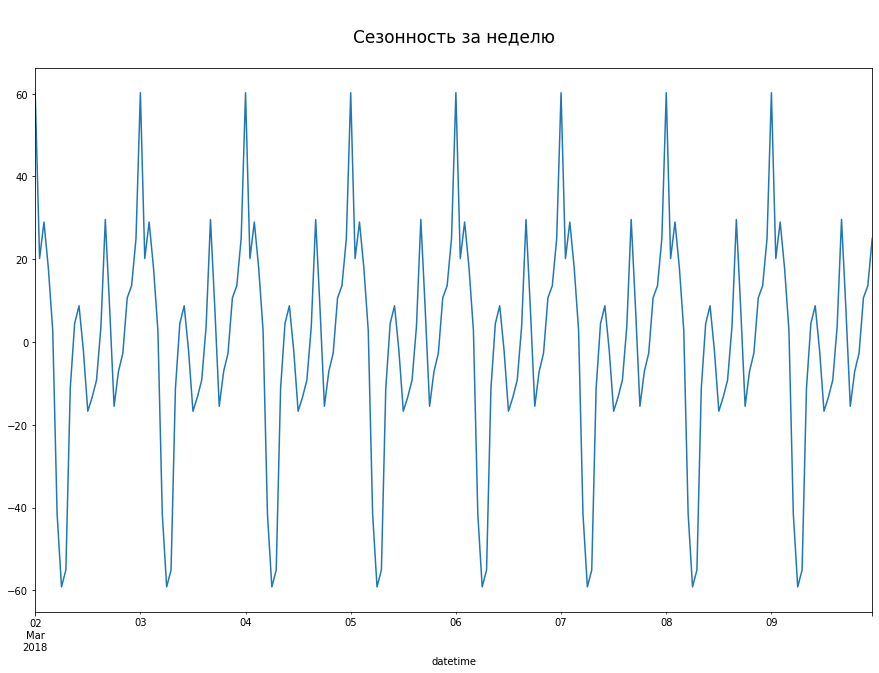

In [18]:
decomposed.seasonal['2018-03-02':'2018-03-09'].plot(ax=plt.gca(), figsize=(15, 10)).set_title('\n'+'Сезонность за неделю'+'\n', fontsize=17);

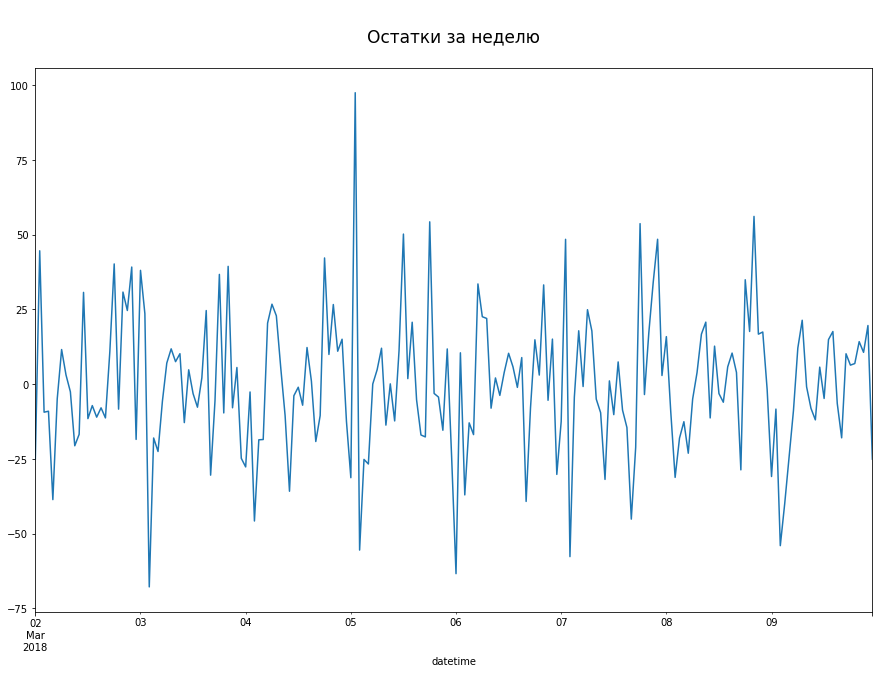

In [19]:
decomposed.resid['2018-03-02':'2018-03-09'].plot(ax=plt.gca(), figsize=(15, 10)).set_title('\n'+'Остатки за неделю'+'\n', fontsize=17);

### Вывод

Можно сказать, что по результатам проведенного анализа дни похожи друг на друга, и не сильно зависят от месяца, главное учитывать, что количество заказов растет, это связано, вероянто, с тем, что сервис развивается и им пользуются все больше людей. Это не может не оказать влияние на результаты обучения и в дальнейшем это необходимо учитывать.

Также очевидна зависимость от дня недели, видна четкая сезонность по неделе. В целом существуют выбросы в датасете, слишком мало или слишком много заказов такси, например, из-за исключительных, праздничных дней. Попробую при обучении нивелировать данный момент, но не гарантирую, что получится.

Заказы зависят от времени суток и дня недели.

## Обучение

In [20]:
'''
Извини, что запутано, сам хотел как можно проще решить эту проблему, а именно возврата строки 
утро, день, вечер, ночь в зависимости от времени, пришлось делать так как сделал, но проблему решил
Пришлось делать две функции и первую вызывать из второй, это немного неправильно, конечно.
'''

def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    return data

In [21]:
make_features(data, 24, 60)[:3]

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Так как важность фичей показало что лаги от 2 д 23 включительно, оказали наименьшее влияние, решил их удалить, для оптимизации.

In [22]:
data = data.drop(data.loc[:, 'lag_2':'lag_23'].columns, axis=1)

In [23]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [24]:
display(features_train.shape, target_train.shape, features_test.shape, target_test.shape)

(3914, 5)

(3914,)

(442, 5)

(442,)

### Катбуст

Обучать буду модель катбуст, думаю ее одной достаточно.

In [71]:
%%time

cb_model = CatBoostRegressor(loss_function='RMSE',
                          #task_type="GPU",
                          #devices='0:1',
                          iterations=1000,
                          depth=4,
                          learning_rate=0.03)

cb_model.fit(features_train, target_train, verbose=200, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 38.1278899	total: 892us	remaining: 892ms
200:	learn: 23.4028843	total: 148ms	remaining: 588ms
400:	learn: 21.8225041	total: 295ms	remaining: 441ms
600:	learn: 20.6095683	total: 461ms	remaining: 306ms
800:	learn: 19.7599202	total: 619ms	remaining: 154ms
999:	learn: 19.1092049	total: 774ms	remaining: 0us
CPU times: user 867 ms, sys: 81.9 ms, total: 949 ms
Wall time: 1.77 s


### Случайный лес

In [26]:
%%time

tscv = TimeSeriesSplit(n_splits=10)

parameters = {
    'n_estimators': range(50, 251, 5),
    'max_depth': range(2, 30),
    'min_samples_leaf': range(1, 6)
}

model_random_forest = RandomForestRegressor(random_state=12345)

search = RandomizedSearchCV(model_random_forest, parameters, n_iter=5, cv=tscv, scoring='neg_root_mean_squared_error')
search.fit(features_train, target_train)
results = search.cv_results_

print('RMSE on VALID:', '%.4f' %search.best_score_)

RMSE on VALID: -24.5727
CPU times: user 19.2 s, sys: 70.4 ms, total: 19.3 s
Wall time: 19.3 s


Качество такое себе, плюс подбор значений долгий, уменьшу количество итераций, чтобы тебе не ждать долго, если решишь заупстить код.

### Линейная регрессия

In [27]:
%%time

scaler = MinMaxScaler()
X_train = scaler.fit_transform(features_train)

tscv = TimeSeriesSplit(n_splits=2)

parameters = {
    'positive':[False]
}

model_line = LinearRegression()

search_line = RandomizedSearchCV(model_line, parameters, n_iter=1, cv=tscv, scoring='neg_root_mean_squared_error')
search_line.fit(X_train, target_train)
results = search_line.cv_results_

print('RMSE on VALID:', '%.4f' %search_line.best_score_)

RMSE on VALID: -29.1229
CPU times: user 14.4 ms, sys: 227 µs, total: 14.6 ms
Wall time: 18.5 ms


### Проверка на адекватность

In [28]:
pred_dummy1 = target_train.shift()
pred_dummy1.iloc[0] = target_train.iloc[-1]
np.sqrt(mean_squared_error(target_train, pred_dummy1))

36.2252364625901

In [29]:
pred_dummy2 = [target_train.mean()] * len(target_train)
np.sqrt(mean_squared_error(target_train, pred_dummy2))

38.67192139960377

### Важность признаков

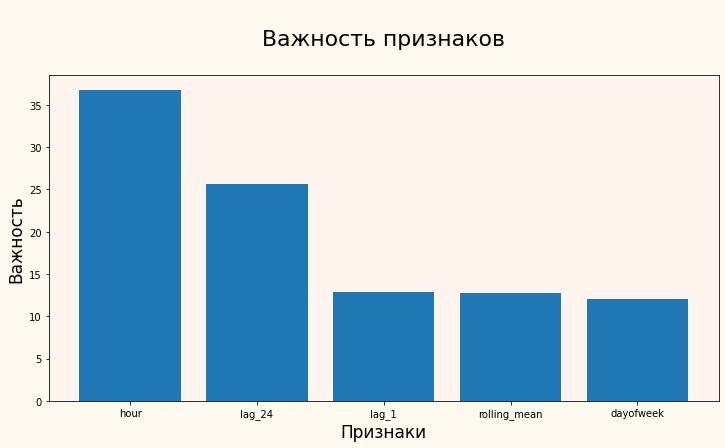

In [30]:
fig, ax = plt.subplots()

feature_importance = pd.Series(dict(zip(features_train.columns, cb_model.get_feature_importance()))).sort_values(ascending=False)

ax.bar(feature_importance.index, feature_importance.values)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
plt.title('\n'+'Важность признаков'+'\n', fontsize=22)
plt.ylabel('Важность', fontsize=17)
plt.xlabel('Признаки', fontsize=17)

plt.show()

### Вывод

В процессе обучения добавил признаки, удалил лишние, добавил категорию - время суток - утро, день и т.д. Модель катбуст обучилась с ошибкой примерно 25 заказов на валидационных данных, думаю, лучше вряд ли получится в данный момент с таким подходом. Модель прошла несколько проверок на адекватность и доказала предиктивную силу. Просмотрена важность признаков

## Тестирование

In [72]:
pred_test = cb_model.predict(features_test)
np.sqrt(mean_squared_error(target_test, pred_test))

44.06856192893891

### Проверка на адекватность

In [32]:
pred_dummy1 = target_test.shift()
pred_dummy1.iloc[0] = target_train.iloc[-1]
np.sqrt(mean_squared_error(target_test, pred_dummy1))

58.856486242815066

In [33]:
pred_dummy2 = [target_test.mean()] * len(target_test)
np.sqrt(mean_squared_error(target_test, pred_dummy2))

58.549609354757315

### Вывод

Модель прошла тестирование и соответствует минимальным требованиям - не более 48 заказов ошибка, корень из средней квадратичной ошибки. Модель прошла проверку на адекватность на тестовых данных.

## Итоговый вывод

В ходе работы, произведены работы над признаками для модели, выполнено рессемпилирование по каждому часу, в качестве агрегирующей функции - суммирование заказов, добавлены признаки:
 - Скользящая средняя
 - Лаги единица и двадцать третий номер периода остальные удалены из-за малой важности
 - Время дня - утро, день, вечер, ночь
 - Номер дня недели
 - Номер дня месяца

Была выбрана модель катбуст в качестве основной и единственной модели для обучения, есть возможность улучшить качество, для этого требуется изменить минимальные требования. Улучшить можно если выделить больше времени на обучение. 

Модель прошла проверки на адекватность при обучении и тестировании и показала предиктивную силу на тесте - чуть более 47 заказов ошибка, на валидационных данных - чуть более 22 заказов. Наиболее важный признак - 24 лаг (смещение на 24 строки)

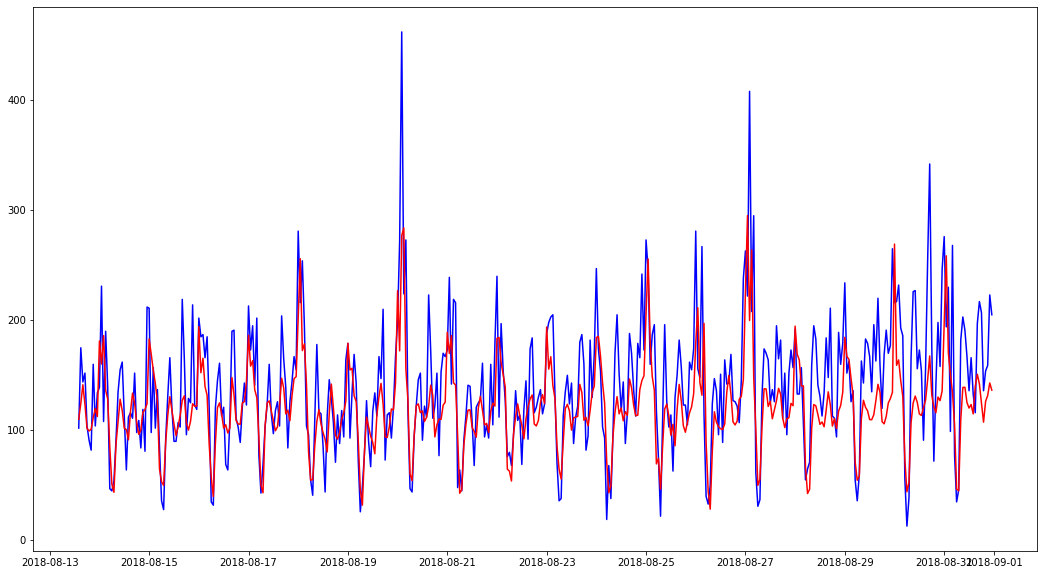

In [34]:
plt.figure(figsize=(18, 10))
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         pred_test,
         'r-');

Как видно, модель неплохо отрабатывает небольшие вслески, но плохо отрабатывает большие колебания (какие-нибудь праздничные дни, когда вечером заказов много и люди пьяные, но понятно, модель не знает этого), также модель себя не очень хорошо показывает в обычные часы, создается впечатление, что она преуменьшает количество заказов (как раз таки из-за выбросов в датасете), возможно, в реальной работе, если бы не существовало бы концпеции глубокого обучения нейросетей, можно было бы автоматически завышать результат, выдаваемый моделью, что повышения точности предсказания в обычные дни.

***


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48